In [ ]:
!pip install rasterio torchmetrics statsmodels optuna scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 23.4 MB/s eta 0:00:00


In [ ]:
import os
import glob
import rasterio

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from rasterio.windows import Window
from rasterio.enums import Resampling
from scipy.interpolate import griddata
from scipy.interpolate import interp1d

# TorchGeo
import torch
import torch.nn as nn
import torch.nn .functional as F
from torchmetrics import Accuracy, Precision, Recall, F1Score
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

from torch.optim.lr_scheduler import ReduceLROnPlateau


# Pre-processing images
import optuna
import torch.optim as optim
from collections import Counter
from skimage.transform import resize
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Post-processing images
from collections import Counter
from sklearn.cluster import KMeans
from scipy.ndimage import median_filter
from statsmodels.nonparametric.smoothers_lowess import lowess
from skimage.morphology import binary_opening, binary_closing

In [ ]:
# ============ DATA PREPARATION AND PREPROCESSING  ============

# Method 1: If all CSV files are in the same directory
csv_files = glob.glob('/content/drive/MyDrive/AGRI/Planting_Method/data/*.csv')  # Update with your path

# Method 2: If you have specific file names
# csv_files = ['file1.csv', 'file2.csv', 'file3.csv']

# Read and merge all CSV files
df_list = []
for file in csv_files:
    temp_df = pd.read_csv(file)
    df_list.append(temp_df)
    print(f"Loaded {file} with {len(temp_df)} rows")

# Concatenate all DataFrames
df_Train = pd.concat(df_list, ignore_index=True)
print(f"\nMerged dataset shape: {df_Train.shape}")

# Now proceed with your preprocessing
df_Train = df_Train.drop(['id', 'gps_lat', 'gps_lon', 'crop_est_d'], axis=1)
df_Label = df_Train['crop_est_m']
df_Train = df_Train.drop(['crop_est_m'], axis=1)

# Convert categorical labels to numerical values
label_mapping = {'Direct-Seeded': 0, 'Transplanted': 1}
df_Label = df_Label.map(label_mapping)

x = df_Train.values
y = df_Label.values

# Verify the unique classes
unique_classes = np.unique(y)
print(f"Unique classes in target labels (zero-indexed): {unique_classes}")

numCol = x.shape[1]
print(f"Number of time steps/bands in 2024 dry season: {numCol}")

# Reshape to (samples, sequence_length, features) for LSTM
X = x.reshape(-1, 1, numCol)  # (13260, 1, 12)
print(f"Reshaped X: {X.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print(f"X_train_tensor shape: {X_train_tensor.shape}")
print(f"y_train_tensor shape: {y_train_tensor.shape}")

Loaded /content/drive/MyDrive/AGRI/Planting_Method/data/reflectance_2025_Dry-Season.csv with 1067 rows
Loaded /content/drive/MyDrive/AGRI/Planting_Method/data/reflectance_2024_Dry-Season.csv with 1579 rows

Merged dataset shape: (2646, 23)
Unique classes in target labels (zero-indexed): [0 1]
Number of time steps/bands in 2024 dry season: 18
Reshaped X: (2646, 1, 18)
X_train_tensor shape: torch.Size([2116, 1, 18])
y_train_tensor shape: torch.Size([2116])


In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert to PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float32)

print(f"Class weights: {class_weights}")

Class weights: tensor([1.5605, 0.7357])


Using mini-batch training with batch size: 32
Number of batches per epoch: 67
Training SimplifiedCNNLSTM for dry season
Training samples: 2116, Validation samples: 530
Class distribution in training: {np.int64(0): np.int64(678), np.int64(1): np.int64(1438)}
Class distribution in validation: {np.int64(0): np.int64(156), np.int64(1): np.int64(374)}
Device: cpu
Epoch [1/500], Loss: 0.9068, Val Loss: 0.6676, Val Acc: 66.60%, Val F1: 0.7656, Pred Dist: {np.int64(0): np.int64(149), np.int64(1): np.int64(381)}, LR: 0.000100
✓ New best F1: 0.7656, Acc: 66.60% - Model saved
Epoch [2/500], Loss: 0.7851, Val Loss: 0.6477, Val Acc: 60.00%, Val F1: 0.6536, Pred Dist: {np.int64(0): np.int64(292), np.int64(1): np.int64(238)}, LR: 0.000100
Epoch [3/500], Loss: 0.7460, Val Loss: 0.6322, Val Acc: 68.49%, Val F1: 0.7746, Pred Dist: {np.int64(0): np.int64(163), np.int64(1): np.int64(367)}, LR: 0.000100
✓ New best F1: 0.7746, Acc: 68.49% - Model saved
Epoch [4/500], Loss: 0.7219, Val Loss: 0.6307, Val Acc:

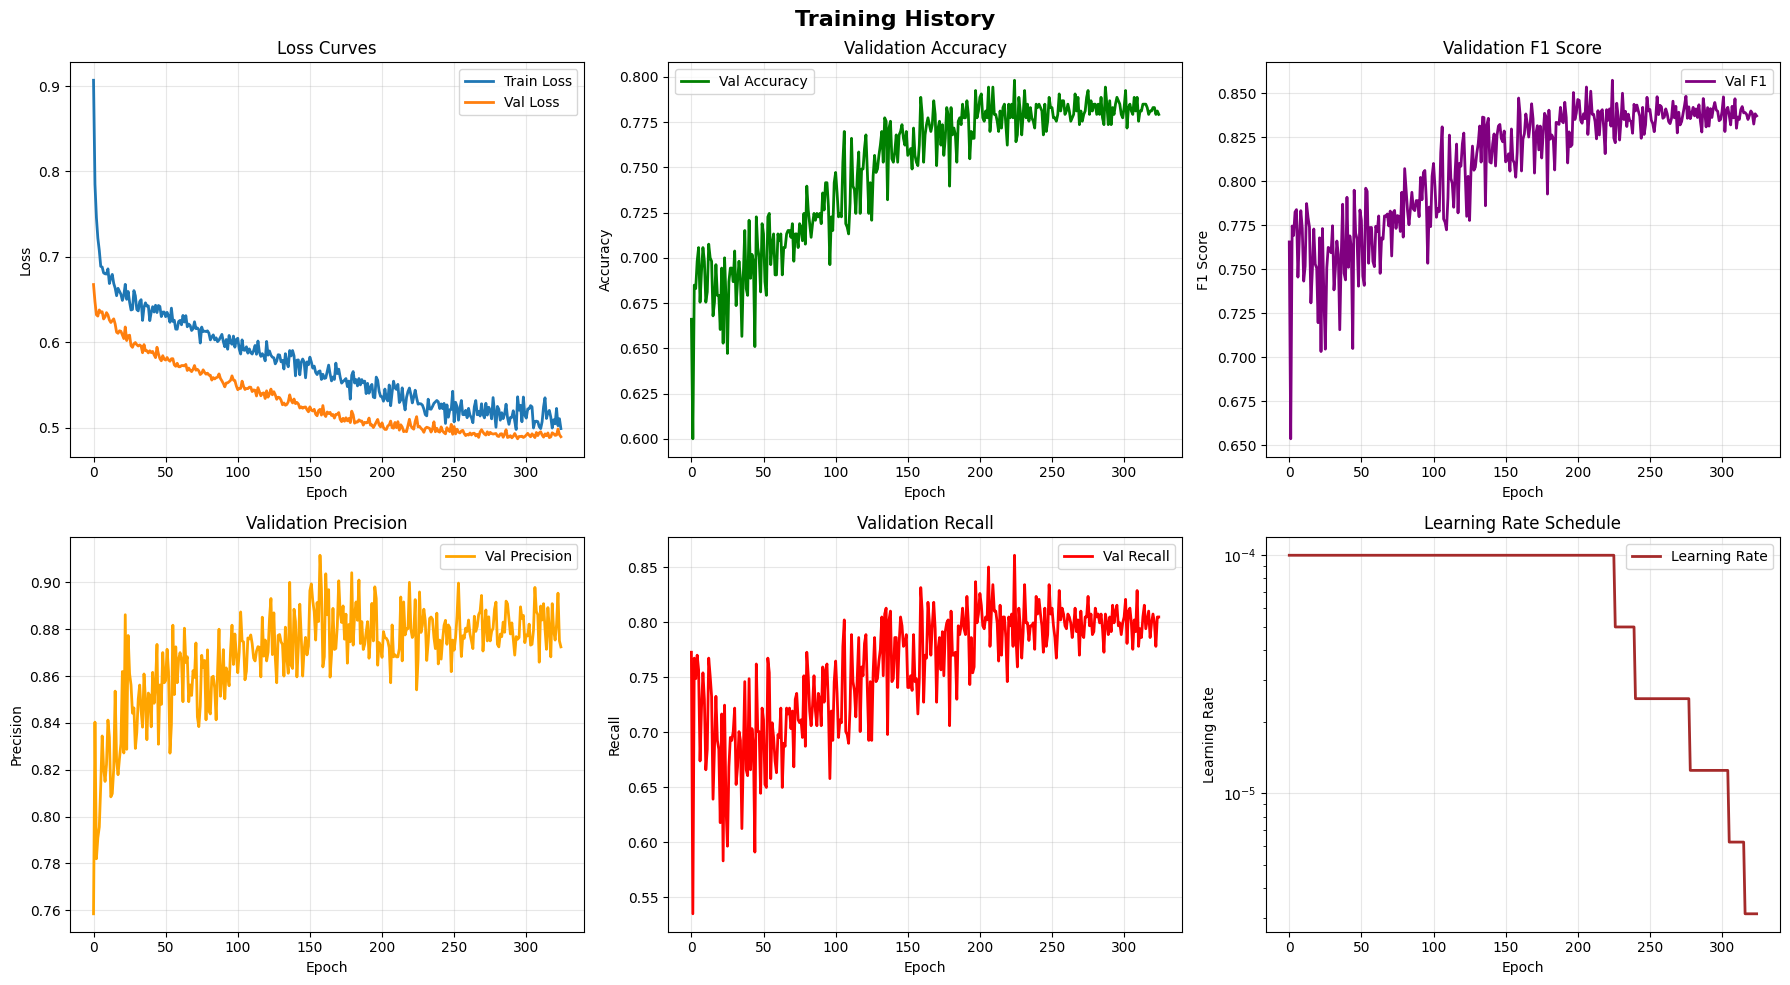

In [ ]:
class SimplifiedCNNLSTM(nn.Module):
    """
    CNN-LSTM architecture for better stability and convergence.
    Good for imbalanced SAR time-series data.
    """
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, num_classes=2, dropout_rate=0.3):
        super().__init__()

        # Simpler CNN with fewer parameters
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )

        # Layer normalization
        self.ln = nn.LayerNorm(hidden_dim * 2)

        # Simple attention
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, num_classes)
        )

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # CNN
        x = x.permute(0, 2, 1)
        cnn_out = self.cnn(x)
        cnn_out = cnn_out.permute(0, 2, 1)

        # LSTM
        lstm_out, _ = self.lstm(cnn_out)
        lstm_out = self.ln(lstm_out)

        # Attention
        attn_scores = self.attention(lstm_out)
        attn_weights = F.softmax(attn_scores, dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)

        # Classification
        return self.classifier(context)


class ImprovedCNNLSTMClassifier(nn.Module):
    """
    Enhanced CNN-LSTM for SAR time-series classification (transplanted vs direct-seeded).

    Key improvements:
    1. Residual connections in CNN
    2. Multi-head self-attention
    3. Temporal positional encoding
    4. Better feature extraction for SAR data
    5. Squeeze-and-Excitation blocks for channel attention
    """
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, num_classes=2,
                 dropout_rate=0.3, num_heads=4):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Temporal positional encoding for SAR time-series
        self.pos_encoder = PositionalEncoding(256, dropout_rate)

        # Enhanced CNN with residual connections and SE blocks
        self.cnn_block1 = ResidualBlock(input_dim, 64, kernel_size=3, dropout=dropout_rate)
        self.cnn_block2 = ResidualBlock(64, 128, kernel_size=3, dropout=dropout_rate)
        self.cnn_block3 = ResidualBlock(128, 256, kernel_size=3, dropout=dropout_rate)

        # Squeeze-and-Excitation for channel attention
        self.se_block = SEBlock(256, reduction=16)

        # Bidirectional LSTM with proper initialization
        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )

        # Multi-head self-attention for better temporal modeling
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=hidden_dim * 2,
            num_heads=num_heads,
            dropout=dropout_rate,
            batch_first=True
        )

        # Layer normalization
        self.ln1 = nn.LayerNorm(hidden_dim * 2)
        self.ln2 = nn.LayerNorm(hidden_dim * 2)

        # Improved attention mechanism with learnable query
        self.attention_query = nn.Parameter(torch.randn(1, 1, hidden_dim * 2))
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

        # Enhanced classifier with residual connection
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate / 2),
            nn.Linear(hidden_dim // 2, num_classes)
        )

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize weights with Xavier/Kaiming initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm1d, nn.LayerNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        batch_size, seq_len, features = x.shape

        # CNN feature extraction with residual connections
        x = x.permute(0, 2, 1)  # [batch, features, seq_len]

        cnn_out = self.cnn_block1(x)
        cnn_out = self.cnn_block2(cnn_out)
        cnn_out = self.cnn_block3(cnn_out)

        # Channel attention
        cnn_out = self.se_block(cnn_out)

        cnn_out = cnn_out.permute(0, 2, 1)  # [batch, seq_len, features]

        # Add positional encoding for temporal information
        cnn_out = self.pos_encoder(cnn_out)

        # LSTM processing
        lstm_out, _ = self.lstm(cnn_out)
        lstm_out = self.ln1(lstm_out)

        # Multi-head self-attention for temporal dependencies
        attn_out, _ = self.multihead_attn(lstm_out, lstm_out, lstm_out)
        attn_out = self.ln2(attn_out + lstm_out)  # Residual connection

        # Weighted attention pooling
        query = self.attention_query.expand(batch_size, -1, -1)
        attn_scores = self.attention(attn_out)
        attn_weights = F.softmax(attn_scores, dim=1)
        context_vector = torch.sum(attn_weights * attn_out, dim=1)

        # Classification
        output = self.classifier(context_vector)

        return output


class ResidualBlock(nn.Module):
    """Residual CNN block with batch normalization"""
    def __init__(self, in_channels, out_channels, kernel_size=3, dropout=0.3):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)

        # Skip connection
        self.skip = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.bn_skip = nn.BatchNorm1d(out_channels) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.bn_skip(self.skip(x))

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.leaky_relu(out, 0.1)
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity  # Residual connection
        out = F.leaky_relu(out, 0.1)

        return out


class SEBlock(nn.Module):
    """Squeeze-and-Excitation block for channel attention"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool1d(1)
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch, channels, _ = x.size()
        y = self.squeeze(x).view(batch, channels)
        y = self.excitation(y).view(batch, channels, 1)
        return x * y.expand_as(x)


class PositionalEncoding(nn.Module):
    """Positional encoding for temporal sequences"""
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


# Training utilities
class FocalLoss(nn.Module):
    """Focal Loss for handling class imbalance"""
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


def train_step(model, data_loader, optimizer, criterion, device, scaler=None):
    """Single training step with mixed precision"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_x, batch_y in data_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()

        if scaler is not None:
            # Mixed precision training
            with torch.cuda.amp.autocast():
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += batch_y.size(0)
        correct += predicted.eq(batch_y).sum().item()

    return total_loss / len(data_loader), 100. * correct / total


def validate(model, data_loader, criterion, device):
    """Validation step"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += batch_y.size(0)
            correct += predicted.eq(batch_y).sum().item()

    return total_loss / len(data_loader), 100. * correct / total


def train_model_full(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
                     criterion, optimizer, scheduler, scaler, device,
                     save_path, season_type='dry',
                     epochs=500, patience=50, max_grad_norm=5.0,
                     use_batch_training=True, batch_size=32):
    """
    Complete training function with early stopping, model saving, and metrics tracking.

    Parameters:
    -----------
    model : nn.Module
        The model to train
    X_train_tensor, y_train_tensor : torch.Tensor
        Training data
    X_test_tensor, y_test_tensor : torch.Tensor
        Validation data
    criterion : nn.Module
        Loss function
    optimizer : torch.optim.Optimizer
        Optimizer
    scheduler : torch.optim.lr_scheduler
        Learning rate scheduler
    scaler : torch.cuda.amp.GradScaler
        Mixed precision scaler
    device : torch.device
        Device to train on
    save_path : str
        Path to save the best model
    season_type : str
        Season type for model naming ('dry' or 'wet')
    epochs : int
        Maximum number of epochs
    patience : int
        Early stopping patience
    max_grad_norm : float
        Maximum gradient norm for clipping
    use_batch_training : bool
        Whether to use mini-batch training (recommended for large datasets)
    batch_size : int
        Batch size for mini-batch training

    Returns:
    --------
    model : nn.Module
        Trained model with best weights loaded
    history : dict
        Training history containing losses and metrics
    """
    from torchmetrics import Accuracy, Precision, Recall, F1Score
    from pathlib import Path
    from torch.utils.data import TensorDataset, DataLoader

    # Create save directory if it doesn't exist
    Path(save_path).parent.mkdir(parents=True, exist_ok=True)

    # Initialize TorchMetrics (GPU-accelerated)
    accuracy_metric = Accuracy(task="binary").to(device)
    precision_metric = Precision(task="binary", average='weighted', zero_division=0).to(device)
    recall_metric = Recall(task="binary", average='weighted', zero_division=0).to(device)
    f1_metric = F1Score(task="binary", average='weighted', zero_division=0).to(device)

    # Create data loaders for mini-batch training
    if use_batch_training:
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        print(f"Using mini-batch training with batch size: {batch_size}")
        print(f"Number of batches per epoch: {len(train_loader)}")

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': [],
        'learning_rate': []
    }

    # Best model tracking
    best_accuracy = 0.0
    best_f1 = 0.0
    patience_counter = 0

    # Check class distribution
    unique, counts = torch.unique(y_train_tensor, return_counts=True)
    print("=" * 80)
    print(f"Training {model.__class__.__name__} for {season_type} season")
    print(f"Training samples: {len(X_train_tensor)}, Validation samples: {len(X_test_tensor)}")
    print(f"Class distribution in training: {dict(zip(unique.cpu().numpy(), counts.cpu().numpy()))}")
    unique_val, counts_val = torch.unique(y_test_tensor, return_counts=True)
    print(f"Class distribution in validation: {dict(zip(unique_val.cpu().numpy(), counts_val.cpu().numpy()))}")
    print(f"Device: {device}")
    print("=" * 80)

    for epoch in range(epochs):
        # ============ Training Phase ============
        model.train()
        epoch_loss = 0.0
        num_batches = 0

        if use_batch_training:
            # Mini-batch training
            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                optimizer.zero_grad()

                # Mixed Precision Forward Pass
                if scaler is not None:
                    with torch.cuda.amp.autocast():
                        outputs = model(batch_x)
                        loss = criterion(outputs, batch_y)

                    scaler.scale(loss).backward()
                    scaler.unscale_(optimizer)
                    nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    outputs = model(batch_x)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
                    optimizer.step()

                epoch_loss += loss.item()
                num_batches += 1

            avg_loss = epoch_loss / num_batches
        else:
            # Full-batch training (original)
            optimizer.zero_grad()

            if scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(X_train_tensor)
                    loss = criterion(outputs, y_train_tensor)

                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(X_train_tensor)
                loss = criterion(outputs, y_train_tensor)
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
                optimizer.step()

            avg_loss = loss.item()

        # ============ Validation Phase ============
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_tensor)
            val_loss = criterion(val_outputs, y_test_tensor)

            # Compute metrics (GPU-accelerated)
            val_preds = torch.argmax(val_outputs, dim=1)
            val_accuracy = accuracy_metric(val_preds, y_test_tensor)
            val_precision = precision_metric(val_preds, y_test_tensor)
            val_recall = recall_metric(val_preds, y_test_tensor)
            val_f1 = f1_metric(val_preds, y_test_tensor)

            # Check prediction distribution
            unique_preds, pred_counts = torch.unique(val_preds, return_counts=True)

        # Update learning rate scheduler
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        # Store history
        history['train_loss'].append(avg_loss)
        history['val_loss'].append(val_loss.item())
        history['val_accuracy'].append(val_accuracy.item())
        history['val_precision'].append(val_precision.item())
        history['val_recall'].append(val_recall.item())
        history['val_f1'].append(val_f1.item())
        history['learning_rate'].append(current_lr)

        # Print progress with prediction distribution
        if epoch < 10 or (epoch + 1) % 5 == 0:
            pred_dist = dict(zip(unique_preds.cpu().numpy(), pred_counts.cpu().numpy()))
            print(f"Epoch [{epoch+1}/{epochs}], "
                  f"Loss: {avg_loss:.4f}, Val Loss: {val_loss.item():.4f}, "
                  f"Val Acc: {val_accuracy.item() * 100:.2f}%, "
                  f"Val F1: {val_f1.item():.4f}, "
                  f"Pred Dist: {pred_dist}, "
                  f"LR: {current_lr:.6f}")

        # ============ Early Stopping & Save Best Model ============
        # Use F1 score as primary metric (better for imbalanced data)
        if val_f1 > best_f1 or (val_f1 == best_f1 and val_accuracy > best_accuracy):
            best_accuracy = val_accuracy
            best_f1 = val_f1
            patience_counter = 0

            # Save best model
            model_save_path = f"{save_path}/CNN-LSTM_{season_type}_model.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_accuracy': best_accuracy.item(),
                'best_f1': best_f1.item(),
                'val_loss': val_loss.item(),
                'history': history
            }, model_save_path)

            if (epoch + 1) % 10 == 0 or epoch < 10:
                print(f"✓ New best F1: {best_f1.item():.4f}, Acc: {best_accuracy.item() * 100:.2f}% - Model saved")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n{'=' * 80}")
                print(f"Early stopping triggered at epoch {epoch+1}")
                print(f"Best validation F1: {best_f1.item():.4f}, Accuracy: {best_accuracy.item() * 100:.2f}%")
                print(f"{'=' * 80}")
                break

    # ============ Load Best Model ============
    print(f"\nLoading best model from {model_save_path}...")
    checkpoint = torch.load(model_save_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✓ Loaded model with best F1: {best_f1.item():.4f}, Accuracy: {best_accuracy.item() * 100:.2f}%")
    print(f"✓ Trained for {checkpoint['epoch']+1} epochs")

    return model, history


def load_trained_model(model_path, model, device, load_optimizer=False, load_scheduler=False):
    """
    Load a trained model from checkpoint.

    Parameters:
    -----------
    model_path : str
        Path to the saved model checkpoint
    model : nn.Module
        Model instance to load weights into
    device : torch.device
        Device to load the model on
    load_optimizer : bool
        Whether to load optimizer state
    load_scheduler : bool
        Whether to load scheduler state

    Returns:
    --------
    model : nn.Module
        Model with loaded weights
    checkpoint : dict
        Full checkpoint dictionary (contains history, metrics, etc.)
    """
    checkpoint = torch.load(model_path, map_location=device)

    # Handle different checkpoint formats
    if 'model_state_dict' in checkpoint:
        # New format (from train_model_full)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"✓ Loaded model from epoch {checkpoint.get('epoch', 'unknown')}")
        print(f"✓ Best validation accuracy: {checkpoint.get('best_accuracy', 'unknown'):.4f}")
    else:
        # Old format (direct state_dict)
        model.load_state_dict(checkpoint)
        print(f"✓ Loaded model state_dict")

    model.to(device)
    model.eval()

    return model, checkpoint


def save_model_for_inference(checkpoint_path, output_path, plot_path, device='cpu'):
    """
    Extract just the model weights from a checkpoint for easy loading.

    Parameters:
    -----------
    checkpoint_path : str
        Path to the full checkpoint file
    output_path : str
        Path to save the model-only file
    device : str
        Device to load checkpoint on
    """
    checkpoint = torch.load(checkpoint_path, map_location=device)

    if 'model_state_dict' in checkpoint:
        model_state = checkpoint['model_state_dict']
    else:
        model_state = checkpoint

    torch.save(model_state, output_path)
    print(f"✓ Saved model weights to {output_path}")
    print(f"  Original checkpoint size: {os.path.getsize(checkpoint_path) / 1024 / 1024:.2f} MB")
    print(f"  Model-only size: {os.path.getsize(output_path) / 1024 / 1024:.2f} MB")
    """
    Plot training history including loss curves and metrics.

    Parameters:
    -----------
    history : dict
        Training history from train_model_full
    save_path : str, optional
        Path to save the plot
    """
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Training History', fontsize=16, fontweight='bold')

    # Loss curves
    axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Loss Curves')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy
    axes[0, 1].plot(history['val_accuracy'], label='Val Accuracy', linewidth=2, color='green')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Validation Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # F1 Score
    axes[0, 2].plot(history['val_f1'], label='Val F1', linewidth=2, color='purple')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('F1 Score')
    axes[0, 2].set_title('Validation F1 Score')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Precision
    axes[1, 0].plot(history['val_precision'], label='Val Precision', linewidth=2, color='orange')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Validation Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Recall
    axes[1, 1].plot(history['val_recall'], label='Val Recall', linewidth=2, color='red')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].set_title('Validation Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Learning Rate
    axes[1, 2].plot(history['learning_rate'], label='Learning Rate', linewidth=2, color='brown')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Learning Rate')
    axes[1, 2].set_title('Learning Rate Schedule')
    axes[1, 2].set_yscale('log')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()

    if plot_path:
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"✓ Training history plot saved to {plot_path}")

    plt.show()


# Example usage
if __name__ == "__main__":
    import numpy as np
    from torch.optim.lr_scheduler import ReduceLROnPlateau

    # ============ TRAINING  ============

    model = SimplifiedCNNLSTM(
         input_dim=18,
         hidden_dim=128,
         num_layers=2,
         num_classes=2,
         dropout_rate=0.4
    ).to(device)

    # Focal Loss or weighted CrossEntropyLoss
    # criterion = FocalLoss(alpha=0.25, gamma=2.0)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
    # scaler = None  # Not needed for CPU

    # # Train with mini-batches
    model, history = train_model_full(
         model=model,
         X_train_tensor=X_train_tensor,
         y_train_tensor=y_train_tensor,
         X_test_tensor=X_test_tensor,
         y_test_tensor=y_test_tensor,
         criterion=criterion,
         optimizer=optimizer,
         scheduler=scheduler,
         scaler=scaler,
         device=device,
         save_path='/content/drive/MyDrive/AGRI/Planting_Method/model',
         season_type='dry',
         epochs=500,
         patience=100,
         use_batch_training=True,
         batch_size=32
    )


    # Save model-only weights for easier loading
    save_model_for_inference(
         checkpoint_path='/content/drive/MyDrive/AGRI/Planting_Method/model/CNN-LSTM_dry_model.pth',
         output_path='/content/drive/MyDrive/AGRI/Planting_Method/model/CNN-LSTM_dry_weights.pth',
         plot_path='/content/drive/MyDrive/AGRI/Planting_Method/model',
         device='cpu'
    )